# General trace loader
Interface for loading various traces. Tasks include:
- Resolving class imbalance (TODO)
- Noise reduction (TODO)
- General trace format (DOING)

In [52]:
from settings.ascad import ASCADData, ASCADDataType
from collections import Counter
import pandas as pd
import seaborn as sns
from settings.cache import cache_np
sns.set_style("whitegrid")

In [53]:
import numpy as np

class ASCAD:
    def __init__(self):
        self.default = TraceGroup(ASCADData.random_key(), ASCADData.data_range)
        self.random = TraceGroup(ASCADData.random_key(), ASCADData.data_range, True)
        self.desync_50 = TraceGroup(ASCADData.random_key(ASCADDataType.desync_50), ASCADData.data_range)
        self.desync_100 = TraceGroup(ASCADData.random_key(ASCADDataType.desync_50), ASCADData.data_range)

class TraceGroup:
    def __init__(self, trace_group, trace_range, shuffle=False):
        self.profile = TraceCategory(trace_group["Profiling_traces"], trace_range, shuffle)
        self.attack = TraceCategory(trace_group["Attack_traces"], trace_range, shuffle)

class TraceCategory:
    def __init__(self, trace_category, trace_range, shuffle=False):
        self.t_range = trace_range

        self.traces = np.array(trace_category["traces"])
        self.labels = np.array(trace_category["labels"])

        if shuffle:
            np.random.shuffle(self.labels)

        self.tk_cache = {}
        self.ct_cache = {}

    def filter_traces(self, label):
        if label not in self.tk_cache:
            ixs = np.where(np.array(self.labels) == label)[0]
            self.tk_cache[label] = np.array(self.traces[ixs])

        return self.tk_cache[label]

    def contingency_table(self, label):
        """
        Builds a contingency table from traces from the dataset for a given label.

        :param label: the label for which traces the contingency table will be build.
        :return: the contingency table as a numpy array.
        """
        if label not in self.ct_cache:
            df = pd.DataFrame([Counter(bins) for bins in self.filter_traces(label)])
            res = df.sum().sort_index().reindex(self.t_range, fill_value=0).values
            self.ct_cache[label] = np.array(res, dtype=int)

        return self.ct_cache[label]

In [54]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [55]:
ascad.default.profile.filter_traces(1).shape

(768, 1400)

<AxesSubplot:>

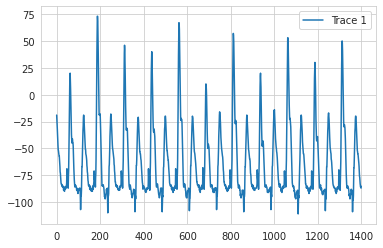

In [56]:
T1 = ascad.default.profile.traces[0]
sns.lineplot(data=pd.DataFrame(T1, columns=["Trace 1"]))

<AxesSubplot:>

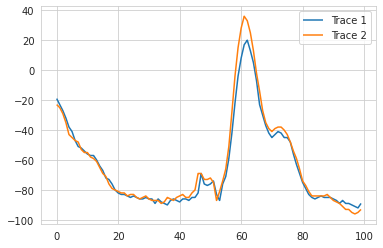

In [57]:
T2 = ascad.default.profile.traces[100]
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[:100], columns=["Trace 1", "Trace 2"]))

### Estimated mean of the traces.

In [58]:
ascad.default.profile.traces.mean()

-63.592529775

### Variance of all traces.

In [59]:
ascad.default.profile.traces.var()

1149.782548447886

### Mean and variance between all traces.

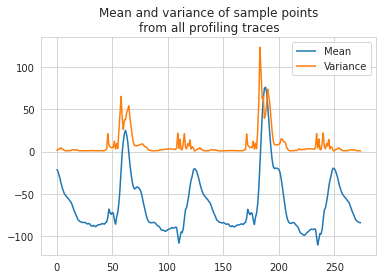

In [60]:
import matplotlib.pyplot as plt

DEFAULT_CUTOFF = 275

def plot_mv_traces(traces, cutoff=DEFAULT_CUTOFF):
    df_mv = pd.DataFrame(list(zip(traces.mean(axis=0), traces.var(axis=0)))[:cutoff], columns=["Mean", "Variance"])

    title = "Mean and variance of sample points\nfrom all profiling traces"
    sns.lineplot(dashes=[(1, 0), (1, 0)], data=df_mv).set_title(title)

def mv_diff(left, right):
    mean_diff = left.mean(axis=0) - right.mean(axis=0)
    var_diff = left.var(axis=0) - right.var(axis=0)

    return mean_diff, var_diff

def plot_mv_diff(left, right, title, cutoff=DEFAULT_CUTOFF):
    cols = ["Mean difference", "Variance difference"]
    df_mv_diff = pd.DataFrame(list(zip(*mv_diff(left, right)))[:cutoff], columns=cols)
    sns.lineplot(data=df_mv_diff[cols[0]])

    ax2 = plt.twinx()
    sns.lineplot(data=df_mv_diff[cols[1]], color=sns.color_palette()[1], ax=ax2).set_title(title)


plot_mv_traces(ascad.default.profile.traces)

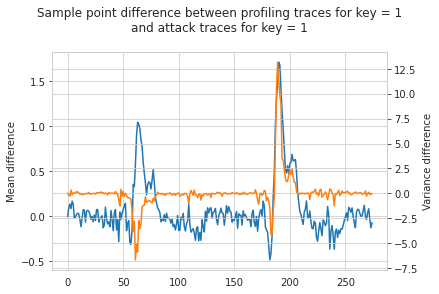

In [61]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 1\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(1), TITLE)


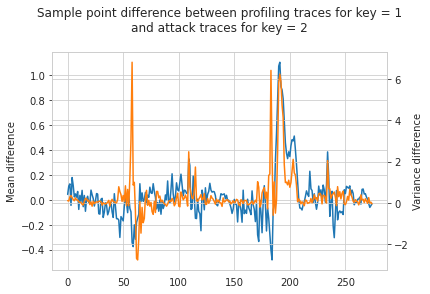

In [62]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 2\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(2), TITLE)

### Leakage assessment

Sample point averages per key.

First order leakage in first round?

In [63]:
from scipy.stats import skew, kurtosis

def stat_order(a: np.array, order):
    if order == 1:
        return a.mean(axis=0)
    if order == 2:
        return a.var(axis=0)
    if order == 3:
        return skew(a, axis=0)
    if order == 4:
        return kurtosis(a, axis=0)

    Exception(f"Order not implemented: {order}")

### Order difference detection tool

Uses the attack traces, though.

In [64]:
def moment_difference(db, moment, left=1, right=2):
    # Differences in means with different keys.
    diff_norm_neq = stat_order(db.default.profile.filter_traces(left), moment) - \
                     stat_order(db.default.attack.filter_traces(right), moment)

    # Differences in means with equal keys (= noise).
    diff_norm_eq = stat_order(db.default.profile.filter_traces(left), moment) - \
                    stat_order(db.default.attack.filter_traces(left), moment)
    # Differences in random means (= noise).
    diff_rand = stat_order(db.random.profile.traces, moment) - \
                    stat_order(db.random.attack.traces, moment)
    return (diff_norm_neq - diff_rand) - (diff_norm_eq - diff_rand)

def get_moment_differences(db, trace_size=1400, max_moment=3):
    return np.array([np.zeros(trace_size), *[moment_difference(db, i) for i in range(1, max_moment + 1)]])

MOMENT_DIFFERENCES = cache_np("moment_differences", get_moment_differences, ascad)

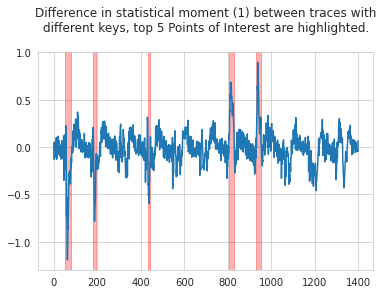

In [65]:
def select_poi(moment, n=5, window=5):
    """
    Selects the top n most interesting points of interest, based on some statistical moment difference.
    """
    diff = abs(MOMENT_DIFFERENCES[moment])
    std = np.std(diff)
    ts = [*(diff > std), *([False] * window)]

    acc = []
    counter, sum_diff = 0, 0.0
    for ix in range(len(ts)):
        if ts[ix]:
            counter += 1
            sum_diff += diff[ix]

        elif counter >= window:
            avg_diff = sum_diff / counter
            # TODO insert filter here.
            acc.append((ix - counter, ix, avg_diff))
            counter, sum_diff = 0, 0.0

    if len(acc) == 0:
        return []

    return pd.DataFrame(acc).sort_values(2, ascending=False).head(n)[[0,1]].values

def plot_poi(moment):
    fig, ax = plt.subplots()
    data = MOMENT_DIFFERENCES[moment]
    top_n = 5

    title = f"Difference in statistical moment ({moment}) between traces with\ndifferent keys, " \
            f"top {top_n} Points of Interest are highlighted.\n"
    sns.lineplot(data=data).set_title(title)

    for a, b in select_poi(moment, top_n):
        ax.axvspan(a, b, alpha=0.3, color='red')

    plt.show()

plot_poi(1)

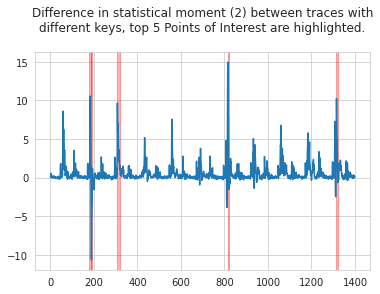

In [66]:
plot_poi(2)

# TODO Next steps:

- Try out the effectiveness of other PoI in $\chi^2$.
- Try out the effectiveness of area outside PoI in $\chi^2$.
- Come up with proper PoI filter for e.g. moments >= 3

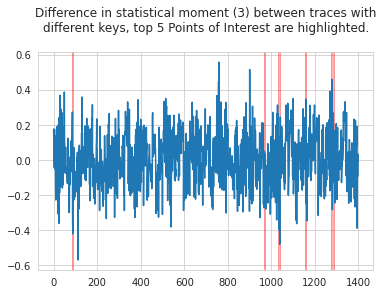

In [67]:
plot_poi(3)

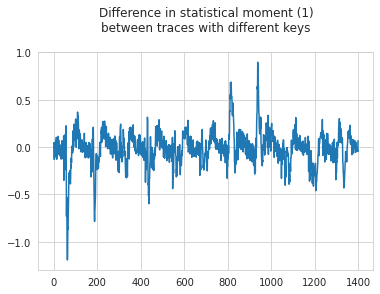

In [68]:
def plot_moment(moment):
    title = f"Difference in statistical moment ({moment})\nbetween traces with different keys\n"
    sns.lineplot(data=MOMENT_DIFFERENCES[moment]).set_title(title)

plot_moment(1)

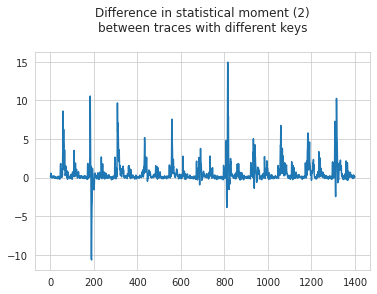

In [69]:
plot_moment(2)

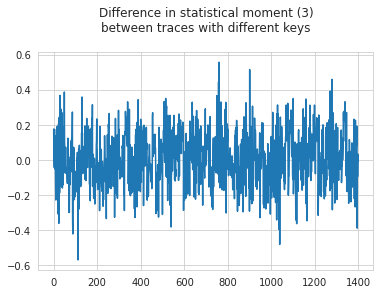

In [70]:
plot_moment(3)

<AxesSubplot:title={'center':'Difference in statistical orders\nbetween traces with different keys\n'}>

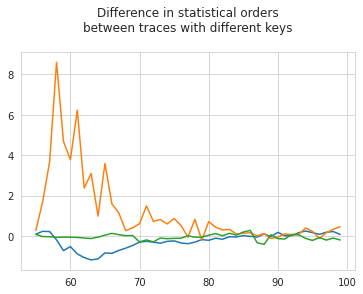

In [71]:
def select_range(line, a=55, b=100):
    return dict(zip(range(a, b), line[a:b]))

sns.lineplot(data=select_range(MOMENT_DIFFERENCES[1])).set_title(
    "Difference in statistical orders\nbetween traces with different keys\n")
sns.lineplot(data=select_range(MOMENT_DIFFERENCES[2]))
sns.lineplot(data=select_range(MOMENT_DIFFERENCES[3]))

### Application of tests

In [72]:
import scipy.stats as stats

def count(traces, trace_range=256, offset=-.5, max_bins=64):
    pos_traces = traces + round(-trace_range * offset)
    bin_count = np.sum(np.array([np.bincount(sample_pts[55:100], minlength=trace_range) for sample_pts in pos_traces]), axis=0)

    res = np.zeros(max_bins)
    step = round(trace_range / max_bins)

    for ix in range(max_bins):
        res[ix] = np.sum(bin_count[ix * step:(ix + 1) * step])

    return res

count(ascad.default.profile.filter_traces(1))

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 3.600e+01, 2.946e+03, 2.648e+03, 3.437e+03, 4.485e+03,
       7.470e+02, 9.180e+02, 1.005e+03, 7.230e+02, 7.650e+02, 6.050e+02,
       6.950e+02, 8.950e+02, 2.049e+03, 2.887e+03, 1.455e+03, 5.410e+02,
       4.690e+02, 4.250e+02, 4.370e+02, 3.910e+02, 3.810e+02, 3.780e+02,
       3.550e+02, 3.630e+02, 4.750e+02, 5.080e+02, 6.190e+02, 6.530e+02,
       6.580e+02, 6.310e+02, 5.150e+02, 3.050e+02, 1.230e+02, 3.500e+01,
       2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

### Examples from paper
Moriadi et al. (2018), page 214


In [73]:
# Example values from Moriadi et al. (2018), page 214
MORIADI = {
    'F_0': [24, 59, 28, 9],
    'F_1': [23, 57, 20, 0],
    'chi': 8.64,
    'dof': 3,
    'p': 0.0345,
    'p_decimal': 3
}

### Implementation based on paper
Moriadi et al. (2018), page 213

In [74]:
import math
from scipy.integrate import quad
from numpy.testing import assert_almost_equal as almost_equal

def f_chi(x, v):
    if x <= 0:
        return 0

    num = x ** ((v / 2) - 1) * math.e ** (-x / 2)
    den = 2 ** (v / 2) * math.gamma(v / 2)
    return num / den

def p_chi(sum_chi, dof):
    return quad(f_chi, sum_chi, np.inf, args=(dof, ))[0]

almost_equal(p_chi(MORIADI['chi'], MORIADI['dof']), MORIADI['p'], MORIADI['p_decimal'])

def chi_squared(observed, expected):
    categories = np.array([observed, expected])

    # Expected frequency
    sum_cat = np.sum(observed), np.sum(expected)
    sum_oe = np.sum(categories, axis=0)

    sum_all = np.sum(sum_oe)
    nz_ixs = np.nonzero(sum_oe)[0]

    chi_acc = 0.0
    for cat in range(len(categories)):
        for ix in nz_ixs:
            # Expected frequency
            ef = (sum_cat[cat] * sum_oe[ix]) / sum_all
            # Accumulation of chi-squared value
            chi_acc += (categories[cat][ix] - ef) ** 2 / ef

    # Degrees of freedom.
    dof = (len(nz_ixs) - 1) * (len(categories) - 1)

    # return chi_acc, dof
    return p_chi(chi_acc, dof)

almost_equal(chi_squared(MORIADI['F_0'], MORIADI['F_1']), MORIADI['p'], MORIADI['p_decimal'])

ascad.default.profile.filter_traces(1).shape, ascad.default.attack.filter_traces(1).shape

((768, 1400), (385, 1400))

In [ ]:
from tqdm import tqdm


KEY_RANGE = 256
counts = [count(ascad.default.profile.filter_traces(i)) for i in range(KEY_RANGE)]

CHI_P_ALL = np.array([np.zeros(KEY_RANGE)] * KEY_RANGE)

for i in tqdm(range(KEY_RANGE)):
    for j in range(KEY_RANGE):
        CHI_P_ALL[i][j] = 1 - chi_squared(counts[i], counts[j])

 84%|████████▎ | 214/256 [00:13<00:02, 15.71it/s]

In [ ]:
P = 0.01

AVG_SUM_DIFF = 0
SUM_EQ = 0
for i in range(KEY_RANGE):
    SUM_EQ += CHI_P_ALL[i][i] < P
    for j in range(KEY_RANGE):
        AVG_SUM_DIFF += CHI_P_ALL[i][j] < P

AVG_SUM_DIFF /= KEY_RANGE

AVG_SUM_DIFF, SUM_EQ

### Important discovery for $\chi^2$
Twice the number of observations from the same distribution will decimate the p-value.
*In this example: from from $1.0$ to $0.23$*
The number of observed sample point values in the attack set should therefore be multiplied with
$\frac{\text{#traces in profiling set}}{\text{#traces in attack set}}$ to obtain a proper p-value.

In [ ]:
A = np.array([1, 2, 5, 2, 1])
print(stats.chisquare(A, f_exp=A))
print(stats.chisquare(A, f_exp=A * 2))

# Next steps

- Leakage moment detector for statistical moments?

In [ ]:
# Under construction
stats.moment(ascad.random.profile.traces, 2)

In [ ]:
# from settings.nbloader import NotebookLoader
# nb = NotebookLoader().load_module("tvla.classic_la")

### $t$ test
The aim of a t-test is to provide a quantitative value as a probability that the mean μ of two sets are different.

For the $t$-test, high $p$ values give reason to reject H0 being "left and right are from different distributions". The traces should be normally distributed for the
    Student's t-test to work.


In [ ]:
# print("exact: ", nb.calc_t([prof_group.contingency_table(1), prof_group.contingency_table(1)]))
# print("same:  ", nb.calc_t([prof_group.contingency_table(1), att_group.contingency_table(1)]))
# print("diff:  ", nb.calc_t([prof_group.contingency_table(1), att_group.contingency_table(2)]))

### $\chi^2$ test

For $\chi^2$, small p-values give reason to reject $H_0$ =
"the occurrences of these observations are independent".
For $t$, large p-values give reason to reject $H_0$ =
"the samples in both sets are drawn from the same population".

In [ ]:
# print("exact: ", nb.calc_chi([prof_group.contingency_table(1), prof_group.contingency_table(1)]))
# print("same:  ", nb.calc_chi([prof_group.contingency_table(1), att_group.contingency_table(1)]))
# print("diff:  ", nb.calc_chi([prof_group.contingency_table(1), att_group.contingency_table(2)]))

# Failed hypotheses

### Correlation between mean and variance for equal / different traces is important

In [ ]:
np.array([np.corrcoef(mv_diff(ascad.default.profile.filter_traces(i),
                              ascad.default.attack.filter_traces(i)))[0][1] for i in range(256)]).mean()

In [ ]:
np.array([np.corrcoef(mv_diff(ascad.default.profile.filter_traces(1),
                              ascad.default.attack.filter_traces(i)))[0][1] for i in range(256)]).mean()

Differences (1st order statistical moment) and variances (2nd order statistical moment)

In [ ]:
def gen_diff(group: TraceGroup, order=1):
    keys = range(256)
    att_all = stat_order(group.attack.traces, order)
    mean_acc_diff = np.zeros(len(keys))

    for key in keys:
        prof_key = stat_order(group.profile.filter_traces(key), order)
        att_key = stat_order(group.attack.filter_traces(key), order)

        mean_acc_diff[key] = abs(prof_key - att_key).mean() - abs(prof_key - att_all).mean()

    return mean_acc_diff

In [ ]:
_ = sns.boxplot(data=pd.DataFrame({
    "Key vs. all": gen_diff(ascad.default),
    "Randomized": gen_diff(ascad.random)
}), showfliers = False).set_title('First order statistical moment')

In [ ]:
_ = sns.boxplot(data=pd.DataFrame({
    "Key vs. all": gen_diff(ascad.default, 2),
    "Randomized": gen_diff(ascad.random, 2)
}), showfliers = False).set_title('Second order statistical moment')